In [10]:
import neurokit2 as nk
import os
import wfdb
from pathlib import Path
import matplotlib.pyplot as plt

In [6]:
file_path = Path('C:/Users/vinay/Downloads/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0')
file_name = '100'
file = os.path.join(file_path, file_name)

In [7]:
signal, field = wfdb.rdsamp(file)

In [25]:
data = nk.ecg_process(signal[:, 0])

In [26]:
d_frame = data[0]

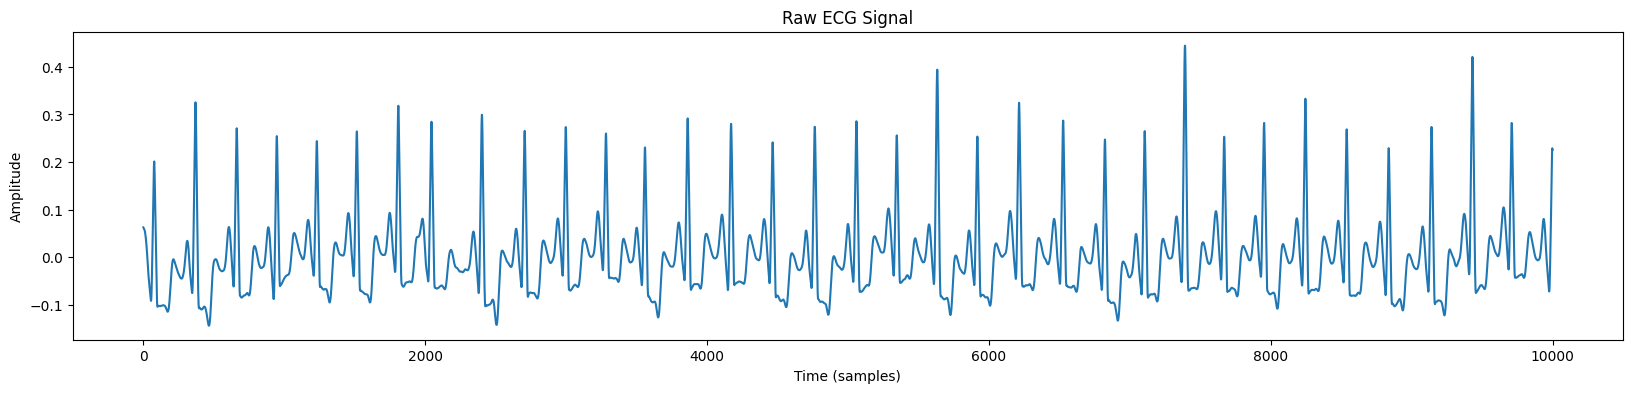

In [68]:
plt.figure(figsize=(20, 4))
plt.plot(d_frame['ECG_Clean'][:10000])  # Plot the first channel
plt.title('Raw ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

In [52]:
input = d_frame['ECG_Clean']
input_array = input.values
input_array

650000

In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Define the model
def build_cnn_lstm_model(input_length):
    input_layer = tf.keras.layers.Input(shape=(input_length, 1))
    
    # CNN Layers
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

    # LSTM Layers
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(32, return_sequences=False)(x)

    # Fully connected layer (optional for further processing)
    feature_output = tf.keras.layers.Dense(64, activation='relu')(x)

    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=feature_output)
    return model


In [60]:
def chunk_signal(signal, window_size, step_size):
    num_chunks = (len(signal) - window_size) // step_size + 1
    
    chunks = np.array([
        signal[i:i + window_size] 
        for i in range(0, len(signal) - window_size + 1, step_size)
    ])
    return chunks[..., np.newaxis]

In [64]:
window_size = 2500
step_size = 1250

ecg_chunks = chunk_signal(input_array, window_size, step_size)

ecg_chunks.shape

(519, 2500, 1)

In [ ]:
model = build_cnn_lstm_model(window_size)
model.summary()

features = model.predict(ecg_chunks, batch_size=32)  # Shape: (num_chunks, 64)

features_df = pd.DataFrame(features, columns=[f'Feature_{i+1}' for i in range(features.shape[1])])

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 2500, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 2500, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 1250, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 1250, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 625, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 625, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 312, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 312, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 156, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 156, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 156, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,816 (1.51 MB)

 Trainable params: 394,816 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
Extracted Features DataFrame:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0        0.0   0.000485   0.001585        0.0   0.001849   0.000000   
1        0.0   0.000369   0.001489        0.0   0.001625   0.000000   
2        0.0   0.000184   0.001133        0.0   0.001609   0.000000   
3        0.0   0.000185   0.001247        0.0   0.001877   0.000009   
4        0.0   0.000389   0.001824        0.0   0.002364   0.000000   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_55  Feature_56  \
0   0.000751        0.0   0.001991    0.000565  ...         0.0    0.000000   
1   0.000627        0.0   0.001995    0.000843  ...         0.0    0.000000   
2   0.000656        0.0   0.002030    0.000756  ...         0.0    0.000000   
3   0.000616        0.0   0.002085    0.000567  ...         0.0    0.000008   
4   0.000575        0.0   0.002810    0.000972  ...         0.0    0.000302   

   Feature_57  Feature_58  F

In [67]:
features_df.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Feature_62,Feature_63,Feature_64
count,519.0,519.000000,519.000000,519.0,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,...,519.0,519.000000,519.000000,519.0,519.000000,519.000000,5.190000e+02,519.000000,519.0,519.000000
mean,0.0,0.000191,0.001494,0.0,0.002057,0.000006,0.000553,0.000006,0.002374,0.000897,...,0.0,0.000192,0.000018,0.0,0.001307,0.000075,7.592296e-07,0.000101,0.0,0.001569
std,0.0,0.000208,0.000371,0.0,0.000486,0.000034,0.000406,0.000035,0.000561,0.000236,...,0.0,0.000242,0.000073,0.0,0.000436,0.000131,1.432129e-05,0.000132,0.0,0.000517
min,0.0,0.000000,0.000665,0.0,0.001152,0.000000,0.000000,0.000000,0.001292,0.000465,...,0.0,0.000000,0.000000,0.0,0.000360,0.000000,0.000000e+00,0.000000,0.0,0.000238
25%,0.0,0.000000,0.001244,0.0,0.001775,0.000000,0.000278,0.000000,0.002033,0.000730,...,0.0,0.000000,0.000000,0.0,0.000994,0.000000,0.000000e+00,0.000000,0.0,0.001196
50%,0.0,0.000146,0.001468,0.0,0.002006,0.000000,0.000511,0.000000,0.002334,0.000864,...,0.0,0.000087,0.000000,0.0,0.001270,0.000000,0.000000e+00,0.000038,0.0,0.001520
75%,0.0,0.000307,0.001702,0.0,0.002305,0.000000,0.000769,0.000000,0.002667,0.001027,...,0.0,0.000336,0.000000,0.0,0.001576,0.000122,0.000000e+00,0.000170,0.0,0.001903
max,0.0,0.001926,0.004985,0.0,0.008894,0.000550,0.005277,0.000437,0.009908,0.002100,...,0.0,0.001732,0.000648,0.0,0.003167,0.001750,3.237960e-04,0.000730,0.0,0.003939


In [70]:
features_df.to_excel('ECG_Features.xlsx', index=False)